In [2]:

import sys
sys.path.append("/home/bcheng4/.local/lib/python3.6/site-packages")


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.figsize"] = (8,5)
mpl.rcParams["font.size"] = 13
mpl.rcParams["legend.frameon"] = False

ModuleNotFoundError: No module named 'scipy'

In [56]:
import numpy as np
import pandas as pd
import sys
print(sys.path)

sys.path.append('./src')
import pickle
import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib as mpl
import matplotlib.pyplot as plt
import SolveLinSys
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import CubicSpline
from matplotlib.backends.backend_pdf import PdfPages
from src.supportfunctions import finiteDiff_3D
import os
import argparse

['/home/schen/Projects/TwoCapital/abatement', '/home/schen/.pyenv/versions/3.8.13/lib/python38.zip', '/home/schen/.pyenv/versions/3.8.13/lib/python3.8', '/home/schen/.pyenv/versions/3.8.13/lib/python3.8/lib-dynload', '', '/home/schen/.pyenv/versions/py38/lib/python3.8/site-packages']


In [76]:

# Model parameters
delta   = 0.010
alpha   = 0.115
kappa   = 6.667
mu_k    = -0.043
sigma_k = np.sqrt(0.0087**2 + 0.0038**2)
# Technology
theta        = 3
lambda_bar   = 0.1206
vartheta_bar = 0.0453
# Damage function
gamma_1 = 1.7675/10000
gamma_2 = 0.0022 * 2
# gamma_3 = 0.3853 * 2
# gamma_3_list = np.array([0.])
y_bar = 2.
y_bar_lower = 1.5


theta_ell = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
pi_c_o    = np.ones_like(theta_ell)/len(theta_ell)
sigma_y   = 1.2 * np.mean(theta_ell)
beta_f    = 1.86 / 1000
# Jump intensity
zeta      = 0.00
psi_0     = 0.005
psi_1     = 1/2
sigma_g   = 0.016
# Tech jump
lambda_bar_first = lambda_bar / 2
vartheta_bar_first = vartheta_bar / 2
lambda_bar_second = 1e-9
vartheta_bar_second = 0.

# Grids Specification
# Coarse Grids
K_min = 4.00
K_max = 9.00
hK    = 0.10
K     = np.arange(K_min, K_max + hK, hK)
nK    = len(K)
Y_min = 0.
Y_max = 5.
hY    = 0.10 # make sure it is float instead of int
Y     = np.arange(Y_min, Y_max + hY, hY)
nY    = len(Y)
L_min = - 5.
L_max = - 0.
hL    = 0.1
L     = np.arange(L_min, L_max,  hL)
nL    = len(L)


Y_min_short = 0.
Y_max_short = 3.
Y_short     = np.arange(Y_min_short, Y_max_short + hY, hY)
nY_short    = len(Y_short)


In [77]:
K.shape,Y_short.shape,L.shape

((51,), (31,), (50,))

In [78]:
def Damage_Intensity(Yt, y_bar_lower=1.5):
    r_1 = 1.5
    r_2 = 2.5
    Intensity = r_1 * (np.exp(r_2 / 2 * (Yt - y_bar_lower)**2) -1) * (Yt > y_bar_lower)
    return Intensity

In [79]:

def simulate_pre(
    grid = (), model_args = (), controls = (), initial=(np.log(85/0.115), 1.1, -3.7), 
    T0=0, T=40, dt=1/12,
    printing=False):

    K, Y, L = grid

    if printing==True:
        print("K_min={},K_max={},Y_min={},Y_max={},L_min={},L_max={}" .format(K.min(),K.max(),Y.min(),Y.max(),L.min(),L.max()))

    K_min, K_max, Y_min, Y_max, L_min, L_max = min(K), max(K), min(Y), max(Y), min(L), max(L)
    hK, hY = K[1] - K[0], Y[1] - Y[0]
    (K_mat, Y_mat, L_mat) = np.meshgrid(K, Y, L, indexing = 'ij')

    delta, mu_k, kappa, sigma_k, beta_f, zeta, psi_0, psi_1, sigma_g, theta, lambda_bar, vartheta_bar, = model_args
    ii, ee, xx, g_tech, g_damage, pi_c = controls
    n_climate = len(pi_c)

    method = 'linear'
    years  = np.arange(T0, T0 + T + dt, dt)
    pers   = len(years)
       

    # setting up grids
    stateSpace = np.hstack([
        K_mat.reshape(-1,1,order = "F"), 
        Y_mat.reshape(-1,1,order = "F"),
        L_mat.reshape(-1,1,order = "F"),
    ])

    # some parameters remaiend unchanged across runs
    gamma_1  = 0.00017675
    gamma_2  = 2. * 0.0022
    beta_f   = 1.86 / 1000
    sigma_y  = 1.2 * 1.86 / 1000
    
    theta_ell = pd.read_csv("../data/model144.csv", header=None).to_numpy()[:, 0]/1000.
    pi_c_o = np.ones(len(theta_ell)) / len(theta_ell)
    pi_c_o = np.array([temp * np.ones(K_mat.shape) for temp in pi_c_o])
    theta_ell = np.array([temp * np.ones(K_mat.shape) for temp in theta_ell])
    args = (delta, alpha, kappa, mu_k, sigma_k, gamma_1, gamma_2, theta_ell, pi_c_o, sigma_y,  theta, vartheta_bar, lambda_bar)

#     v, ME_base, diff = decompose(v0, stateSpace, (K_mat, Y_mat, L_mat), (ii, ee, xx), args=args)

    gridpoints = (K, Y, L)

    i_func = RegularGridInterpolator(gridpoints, ii)
    e_func = RegularGridInterpolator(gridpoints, ee)
    x_func = RegularGridInterpolator(gridpoints, xx)
    tech_func = RegularGridInterpolator(gridpoints, g_tech)
#     ME_base_func = RegularGridInterpolator(gridpoints, ME_base)
    
#     if pre_damage:
    n_damage = len(g_damage)

    damage_func_list = []
    for i in range(n_damage):
        func_i = RegularGridInterpolator(gridpoints, g_damage[i])
        damage_func_list.append(func_i)
        
    climate_func_list = []
    for i in range(n_climate):
        func_i = RegularGridInterpolator(gridpoints, pi_c[i])
        climate_func_list.append(func_i)


    def get_i(x):
        return i_func(x)

    def get_e(x):
        return e_func(x)
    
    def get_x(x):
        return x_func(x)


#     K_0 = np.log(85 / 0.115)
#     Y_0 = 1.1
#     L_0 = -3.7
    
    K_0, Y_0, L_0 = initial

    def mu_K(i_x):
        return mu_k + i_x - 0.5 * kappa * i_x ** 2  - 0.5 * sigma_k ** 2
    
    def mu_L(Xt, state):
        return -zeta + psi_0 * (Xt * (np.exp(state[0] - state[2]) ) )**psi_1 - 0.5 * sigma_g**2
    
    
    hist      = np.zeros([pers, 3])
    i_hist    = np.zeros([pers])
    e_hist    = np.zeros([pers])
    x_hist    = np.zeros([pers])
    scc_hist  = np.zeros([pers])
    gt_tech   = np.zeros([pers])
#     if pre_damage:
    gt_dmg    = np.zeros([n_damage, pers])
    pi_c_t = np.zeros([n_climate, pers])
    
#     ME_base_t = np.zeros([pers])

    mu_K_hist = np.zeros([pers])
    mu_L_hist = np.zeros([pers])

    for tm in range(pers):
        if tm == 0:

            # initial points
            hist[0,:] = [K_0, Y_0, L_0] # logL
            i_hist[0] = get_i(hist[0, :])
            e_hist[0] = get_e(hist[0, :])
            x_hist[0] = get_x(hist[0, :])
            mu_K_hist[0] = mu_K(i_hist[0])
            mu_L_hist[0] = mu_L(x_hist[0], hist[0,:])
            gt_tech[0] = tech_func(hist[0, :])
#             if pre_damage:
            for i in range(n_damage):
                damage_func = damage_func_list[i]
                gt_dmg[i, 0] = damage_func(hist[0, :])
            
            for i in range(n_climate):
                climate_func = climate_func_list[i]
                pi_c_t[i, 0] = climate_func(hist[0, :])
            
#             gt_dmg[0] = damage_func(hist[0, :])
#             ME_base_t[0] = ME_base_func(hist[0, :])
            
#             scc_hist[0] = scc_func(hist[0, :])

        else:
            # other periods
            # print(hist[tm-1,:])
            i_hist[tm] = get_i(hist[tm-1,:])
            e_hist[tm] = get_e(hist[tm-1,:])
            x_hist[tm] = get_x(hist[tm-1,:])
            gt_tech[tm] = tech_func(hist[tm-1,:])
#             if pre_damage:
            for i in range(n_damage):
                damage_func = damage_func_list[i]
                gt_dmg[i, tm] = damage_func(hist[tm-1, :])

            for i in range(n_climate):
                climate_func = climate_func_list[i]
                pi_c_t[i, tm] = climate_func(hist[tm -1, :])
                
#             ME_base_t[tm] = ME_base_func(hist[tm-1, :])
            

            mu_K_hist[tm] = mu_K(i_hist[tm])
            mu_L_hist[tm] = mu_L(x_hist[tm], hist[tm-1, :])

            hist[tm,0] = hist[tm-1,0] + mu_K_hist[tm] * dt #logK
            hist[tm,1] = hist[tm-1,1] + beta_f * e_hist[tm] * dt
            hist[tm,2] = hist[tm-1,2] + mu_L_hist[tm] * dt # logλ

        if printing==True:
            print("time={}, K={},Y={},L={},mu_K={},mu_Y={},mu_L={},ii={},ee={},xx={}" .format(tm, hist[tm,0],hist[tm,1],hist[tm,2],mu_K_hist[tm],beta_f * e_hist[tm],mu_L_hist[tm],ii.max(),ee.max(),xx.max()))
        
    
    
        # using Kt instead of K0
    jt = 1 - e_hist/ (alpha * lambda_bar * np.exp(hist[:, 0]))
    jt[jt <= 1e-16] = 1e-16
    LHS = theta * vartheta_bar / lambda_bar * jt**(theta -1)
    MC = delta / (alpha  - i_hist - alpha * vartheta_bar * jt**theta - x_hist)

    
    scc_hist = LHS * 1000
#     scc_0 = ME_base_t / MC * 1000 * np.exp(hist[:, 0])
    
    distorted_tech_intensity = np.exp(hist[:, 2]) * gt_tech
    distorted_tech_prob = 1 - np.exp(- np.cumsum(np.insert(distorted_tech_intensity * dt, 0, 0) ))[:-1]

    true_tech_intensity = np.exp(hist[:, 2]) 
    true_tech_prob = 1 - np.exp(- np.cumsum(np.insert(true_tech_intensity * dt, 0, 0) ))[:-1]
        
#     if pre_damage:
    damage_intensity = Damage_Intensity(hist[:, 1])
    distorted_damage_intensity = np.mean(gt_dmg, axis=0) * damage_intensity
    distorted_damage_prob = 1 - np.exp(- np.cumsum(np.insert(distorted_damage_intensity * dt, 0, 0) ))[:-1]
    
    true_damage_intensity =  damage_intensity
    true_damage_prob = 1 - np.exp(- np.cumsum(np.insert(true_damage_intensity * dt, 0, 0) ))[:-1]

    
    res = dict(
        states= hist, 
        i = i_hist * np.exp(hist[:, 0]), 
        e = e_hist,
        # x = x_hist * np.exp(hist[:, 0]),
        x = x_hist * np.exp(hist[:, 0]),
        scc = scc_hist,
#         scc0 = scc_0,
        gt_tech = gt_tech,
        gt_dmg = gt_dmg,
        distorted_damage_prob=distorted_damage_prob,
        distorted_tech_prob=distorted_tech_prob,
        pic_t = pi_c_t,
#         ME_base = ME_base_t,
        jt = jt,
        LHS = LHS,
        years=years,
        true_tech_prob = true_tech_prob,
        true_damage_prob = true_damage_prob
    )
    
#     if pre_damage:
#         res["gt_dmg"] = gt_dmg
    
    return res

In [80]:
data_1000 = pickle.load(open("./res_data/10damage/xi_a_1000.0_xi_g_1000.0/model_tech1_pre_damage", "rb"))
data_0050 = pickle.load(open("./res_data/10damage/xi_a_0.0002_xi_g_0.05/model_tech1_pre_damage", "rb"))
data_0025 = pickle.load(open("./res_data/10damage/xi_a_0.0002_xi_g_0.025/model_tech1_pre_damage", "rb"))


In [81]:
IntPeriod = 60
timespan = 1/12

In [82]:
model_args = (delta, mu_k, kappa,sigma_k, beta_f, zeta, psi_0, psi_1, sigma_g, theta, lambda_bar, vartheta_bar)


In [83]:
i.shape

(51, 31, 50)

In [84]:
i = data_1000["i_star"]
e = data_1000["e_star"]
x = data_1000["x_star"]
pi_c = data_1000["pi_c"]
g_tech = data_1000["g_tech"]
g_damage =  data_1000["g_damage"]


# g_damage = np.ones((1, nK, nY, nL))
res_1000 = simulate_pre(grid = (K, Y_short, L), model_args = model_args, 
                            controls = (i,e,x, g_tech, g_damage, pi_c), 
                            T0=0, T=IntPeriod, dt=timespan,printing=False)

i = data_0050["i_star"]
e = data_0050["e_star"]
x = data_0050["x_star"]
pi_c = data_0050["pi_c"]
g_tech = data_0050["g_tech"]
g_damage =  data_0050["g_damage"]


# g_damage = np.ones((1, nK, nY, nL))
res_0050 = simulate_pre(grid = (K, Y_short, L), model_args = model_args, 
                            controls = (i,e,x, g_tech, g_damage, pi_c), 
                            T0=0, T=IntPeriod, dt=timespan,printing=False)


i = data_0025["i_star"]
e = data_0025["e_star"]
x = data_0025["x_star"]
pi_c = data_0025["pi_c"]
g_tech = data_0025["g_tech"]
g_damage =  data_0025["g_damage"]


# g_damage = np.ones((1, nK, nY, nL))
res_0025 = simulate_pre(grid = (K, Y_short, L), model_args = model_args, 
                            controls = (i,e,x, g_tech, g_damage, pi_c), 
                            T0=0, T=IntPeriod, dt=timespan,printing=False)

Text(0.5, 0, 'Years')

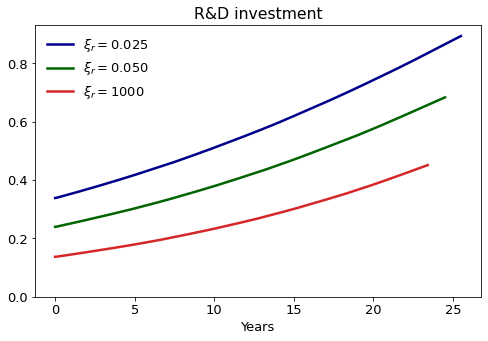

In [88]:
# Xt
plt.plot(res_0025["years"][res_0025["states"][:,1]<1.5], res_0025["x"][res_0025["states"][:,1]<1.5], 
         label="$\\xi_r = 0.025$", color="darkblue")
# plt.plot(res_2p5_1["years"], res_2p5_1["x"], label="$\\xi_r = 0.025$")
plt.plot(res_0025["years"][res_0050["states"][:,1]<1.5], res_0050["x"][res_0050["states"][:,1]<1.5], 
         label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_7p5_1["years"], res_7p5_1["x"], label="$\\xi_r = 0.075$")
plt.plot(res_0025["years"][res_1000["states"][:,1]<1.5], res_1000["x"][res_1000["states"][:,1]<1.5], 
         label="$\\xi_r = 1000$", color="C3")

plt.ylim(0)
plt.legend()
plt.title("R&D investment")
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/Xt.pdf")

Text(0.5, 1.0, 'Distorted probability of damage changes')

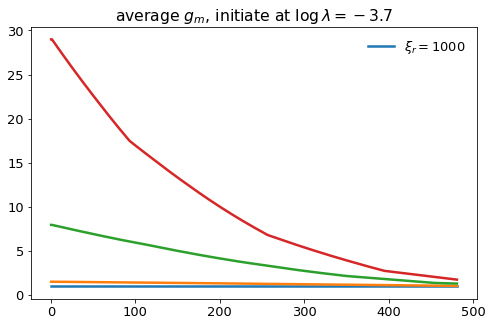

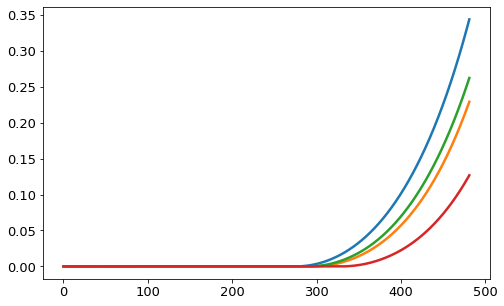

<Figure size 576x360 with 0 Axes>

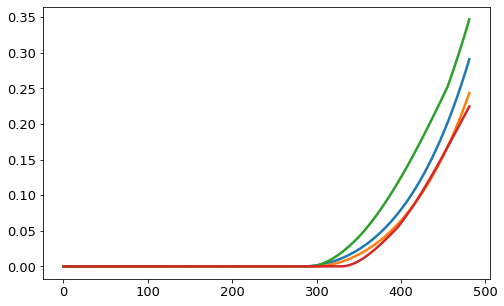

<Figure size 576x360 with 0 Axes>

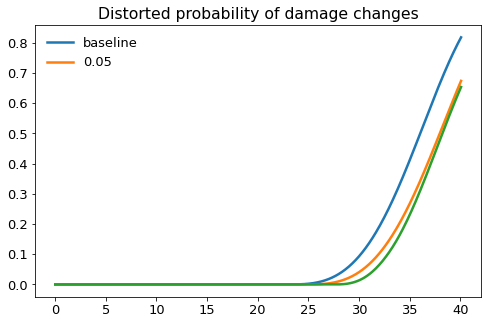

In [24]:
res_1000 = simluate_pre()

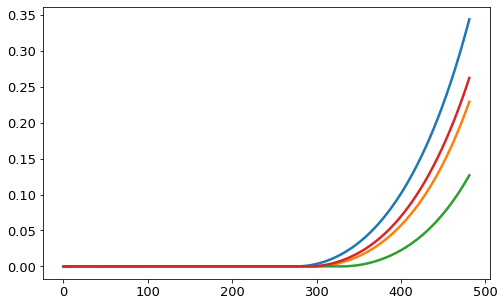

In [25]:
plt.plot(Damage_Intensity(res_1000_1["states"][:,1]) )
# plt.plot(Damage_Intensity(res_7p5_1["states"][:,1]) )
plt.plot(Damage_Intensity(res_5_1["states"][:,1]) )
# plt.plot(Damage_Intensity(res_01_1["states"][:, 1]))
plt.plot(Damage_Intensity(res_1_1["states"][:, 1]))
plt.plot(Damage_Intensity(res_test_1["states"][:,1]) )


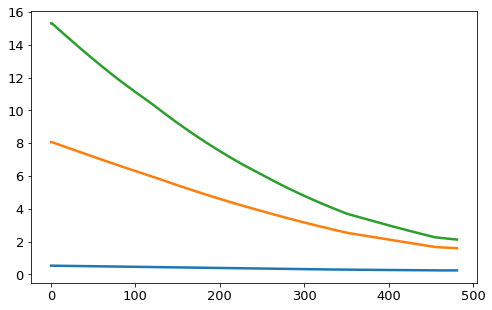

In [26]:
plt.plot(res_test_1["gt_dmg"].T)

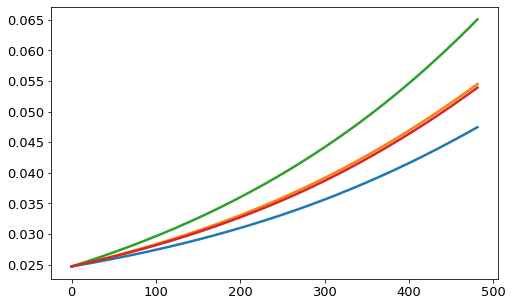

In [27]:
plt.plot(np.exp(res_1000_1["states"][:, 2]))
plt.plot(np.exp(res_5_1["states"][:, 2]))
plt.plot(np.exp(res_1_1["states"][:, 2]))
plt.plot(np.exp(res_test_1["states"][:, 2]))

Text(0.5, 0, 'Years')

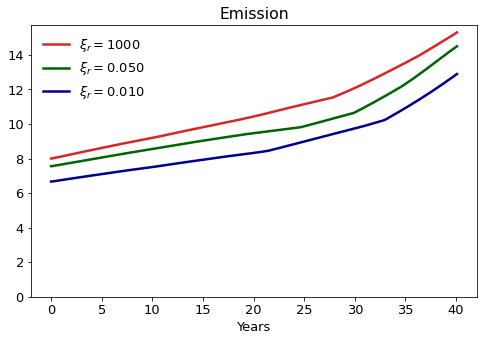

In [28]:
# Et

plt.plot(res_1000_1["years"], res_1000_1["e"], 
         label="$\\xi_r =  1000$", color="C3")
# plt.plot(res_7p5_1["years"], res_7p5_1["e"], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"], res_5_1["e"], 
         label="$\\xi_r= 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"], res_2p5_1["e"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"], res_01_1["e"])
plt.plot(res_1_1["years"], res_1_1["e"], 
         label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_1["years"], res_test_1["e"], 
#          label="$\\xi_r = 0.010$", color="darkorange")
plt.legend()

plt.ylim(0)
plt.title("Emission")
plt.xlabel("Years")

# plt.savefig("figures/xi_comparison/Et.pdf")

Text(0.5, 0, 'Years')

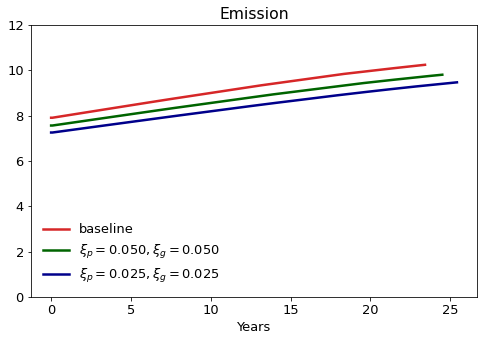

In [29]:
# Et
plt.plot(res_base_1["years"][:t_15_b], res_base_1["e"][:t_15_b], 
         label="baseline", color="C3")


plt.plot(res_5_1["years"][:t_15_5], res_5_1["e"][:t_15_5], 
         label="$\\xi_p =  0.050,  \\xi_g = 0.050$", color="darkgreen")


plt.plot(res_25_1["years"][:t_15_25], res_25_1["e"][:t_15_25], 
         label="$\\xi_p =  0.025,  \\xi_g = 0.025$", color="darkblue")


plt.legend()

plt.ylim(0, 12)
plt.title("Emission")
plt.xlabel("Years")

# plt.savefig("figures/xi_comparison/20damage/Et_1p5.pdf")

Text(0.5, 0, 'Years')

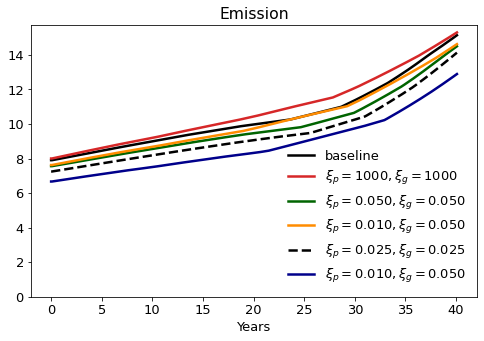

In [30]:
# Et

plt.plot(res_base_1["years"], res_base_1["e"], 
         label="baseline", color="black")
plt.plot(res_1000_1["years"], res_1000_1["e"], 
         label="$\\xi_p =  1000,  \\xi_g = 1000$", color="C3")
# plt.plot(res_7p5_1["years"], res_7p5_1["e"], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"], res_5_1["e"], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"], res_2p5_1["e"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"], res_01_1["e"])

plt.plot(res_test_1["years"], res_test_1["e"], 
         label="$\\xi_p = 0.010, \\xi_g = 0.050$", color="darkorange")
plt.plot(res_25_1["years"], res_25_1["e"], 
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="black", linestyle="dashed")


plt.plot(res_1_1["years"], res_1_1["e"], 
         label="$\\xi_p = 0.010, \\xi_g = 0.050$", color="darkblue")


plt.legend()

plt.ylim(0)
plt.title("Emission")
plt.xlabel("Years")

# plt.savefig("figures/xi_comparison/full/Et.pdf")

Text(0.5, 0, 'Years')

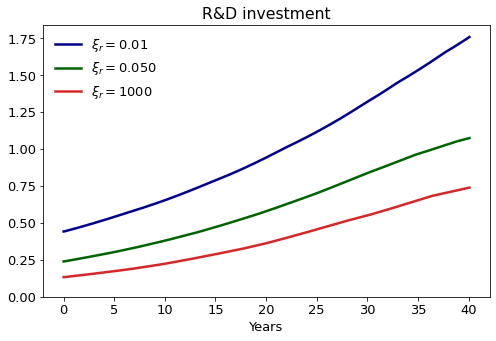

In [31]:
# Xt
plt.plot(res_1_1["years"], res_1_1["x"], 
         label="$\\xi_r = 0.01$", color="darkblue")
# plt.plot(res_2p5_1["years"], res_2p5_1["x"], label="$\\xi_r = 0.025$")
plt.plot(res_5_1["years"], res_5_1["x"], 
         label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_7p5_1["years"], res_7p5_1["x"], label="$\\xi_r = 0.075$")
plt.plot(res_1000_1["years"], res_1000_1["x"], 
         label="$\\xi_r = 1000$", color="C3")

plt.ylim(0)
plt.legend()
plt.title("R&D investment")
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/Xt.pdf")

Text(0.5, 0, 'Years')

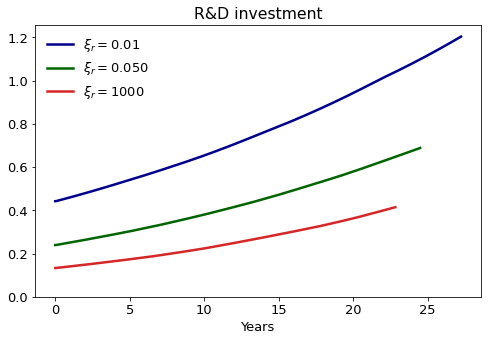

In [13]:
# Xt
plt.plot(res_1_1["years"][:t_15_1], res_1_1["x"][:t_15_1], 
         label="$\\xi_r = 0.01$", color="darkblue")
# plt.plot(res_2p5_1["years"], res_2p5_1["x"], label="$\\xi_r = 0.025$")
plt.plot(res_5_1["years"][:t_15_5], res_5_1["x"][:t_15_5], 
         label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_7p5_1["years"], res_7p5_1["x"], label="$\\xi_r = 0.075$")
plt.plot(res_1000_1["years"][:t_15_1000], res_1000_1["x"][:t_15_1000], 
         label="$\\xi_r = 1000$", color="C3")

plt.ylim(0)
plt.legend()
plt.title("R&D investment")
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/cut/Xt.pdf")

Text(0.5, 0, 'Years')

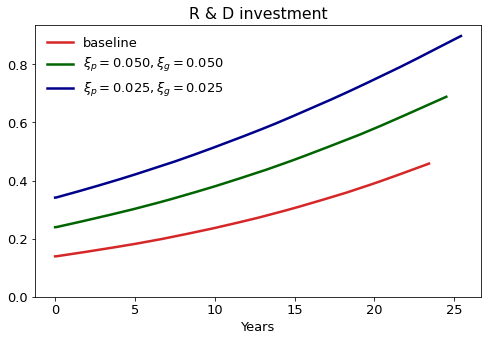

In [16]:
# Xt
plt.plot(res_base_1["years"][:t_15_b], res_base_1["x"][:t_15_b], 
         label="baseline", color="C3")


plt.plot(res_5_1["years"][:t_15_5], res_5_1["x"][:t_15_5], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")


plt.plot(res_25_1["years"][:t_15_25], res_25_1["x"][:t_15_25], 
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")


plt.legend()

plt.ylim(0)
plt.title("R & D investment")
plt.xlabel("Years")

# plt.savefig("figures/xi_comparison/20damage/Xt_1p5.pdf")

Text(0.5, 0, 'Years')

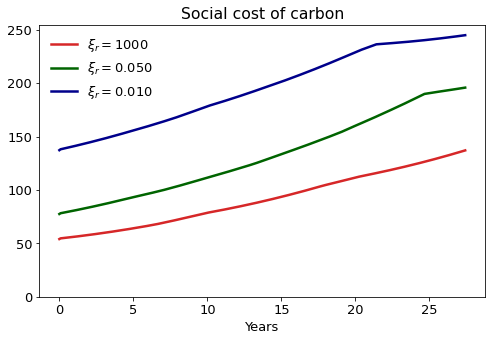

In [17]:
# SCCt

plt.plot(res_1000_1["years"][:330], res_1000_1["scc"][:330], 
         label="$\\xi_r = 1000$", color="C3")
# plt.plot(res_7p5_1["years"][:330], res_7p5_1["scc"][:330], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"][:330], res_5_1["scc"][:330], label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"][:330], res_2p5_1["scc"][:330], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"][:330], res_01_1["scc"][:330], label="$\\xi_r = 0.025$")
plt.plot(res_1_1["years"][:330], res_1_1["scc"][:330], label="$\\xi_r = 0.010$", color="darkblue" )
# plt.plot(res_test_1["years"][:330], res_test_1["scc"][:330], 
#          label="$\\xi_r = 0.01$")

plt.ylim(0)
plt.xlabel("Years")
plt.title("Social cost of carbon")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/SCCt.pdf")

Text(0.5, 0, 'Years')

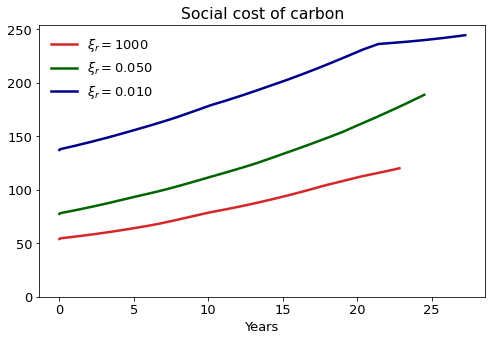

In [18]:
# SCCt

plt.plot(res_1000_1["years"][:t_15_1000], res_1000_1["scc"][:t_15_1000], 
         label="$\\xi_r = 1000$", color="C3")
plt.plot(res_5_1["years"][:t_15_5], res_5_1["scc"][:t_15_5], label="$\\xi_r = 0.050$", color="darkgreen")
plt.plot(res_1_1["years"][:t_15_1], res_1_1["scc"][:t_15_1], label="$\\xi_r = 0.010$", color="darkblue" )

plt.ylim(0)
plt.xlabel("Years")
plt.title("Social cost of carbon")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/cut/SCCt.pdf")

Text(0.5, 0, 'Years')

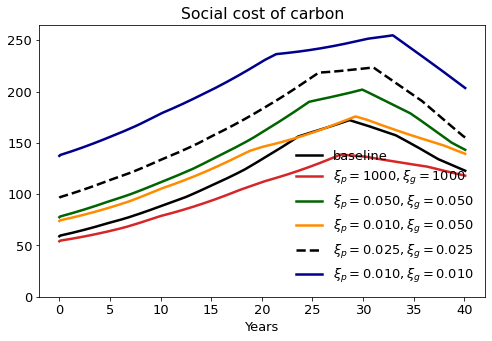

In [19]:
# SCCt - 4

plt.plot(res_base_1["years"] , res_base_1["scc"] , 
         label="baseline", color="black")

plt.plot(res_1000_1["years"] , res_1000_1["scc"] , 
         label="$\\xi_p = 1000,  \\xi_g = 1000$", color="C3")
plt.plot(res_5_1["years"] , res_5_1["scc"] , 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")
plt.plot(res_test_1["years"] , res_test_1["scc"] , 
         label="$\\xi_p = 0.010, \\xi_g = 0.050$", color="darkorange")

plt.plot(res_25_1["years"] , res_25_1["scc"] , 
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="black", linestyle="dashed")
plt.plot(res_1_1["years"] , res_1_1["scc"] , 
         label="$\\xi_p = 0.010, \\xi_g = 0.010$", color="darkblue" )


plt.ylim(0)
plt.xlabel("Years")
plt.title("Social cost of carbon")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/full/SCCt.pdf")

Text(0.5, 0, 'Years')

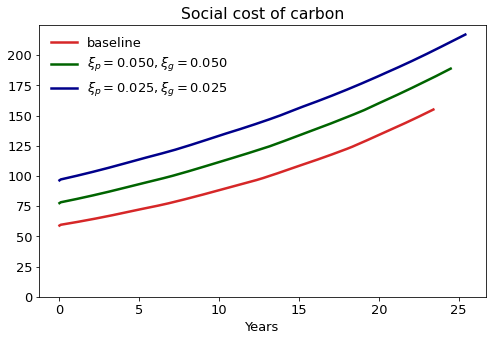

In [22]:
# SCCt - 4

plt.plot(res_base_1["years"][:t_15_b] , res_base_1["scc"][:t_15_b] , 
         label="baseline", color="C3")

plt.plot(res_5_1["years"][:t_15_5] , res_5_1["scc"][:t_15_5] , 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")

plt.plot(res_25_1["years"][:t_15_25] , res_25_1["scc"][:t_15_25] , 
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")


plt.ylim(0)
plt.xlabel("Years")
plt.title("Social cost of carbon")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/20damage/SCCt_1p5.pdf")

Text(0.5, 0, 'Years')

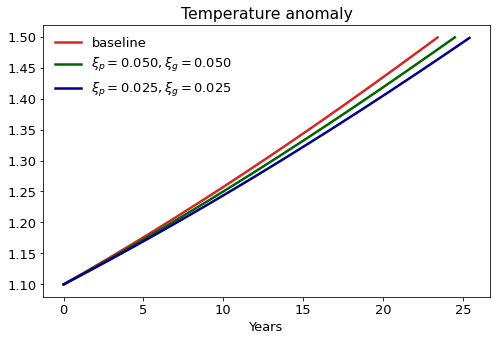

In [25]:
# Intensity tech, I
plt.plot(res_base_1["years"][:t_15_b], res_base_1["states"][:, 1][:t_15_b], 
         label="baseline", color="C3")

plt.plot(res_5_1["years"][:t_15_5], res_5_1["states"][:, 1][:t_15_5], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$",
         color="darkgreen")

plt.plot(res_25_1["years"][:t_15_25], res_25_1["states"][:, 1][:t_15_25],
        label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")



plt.title("Temperature anomaly")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/20damage/Yt_1p5.pdf")

Text(0.5, 0, 'Years')

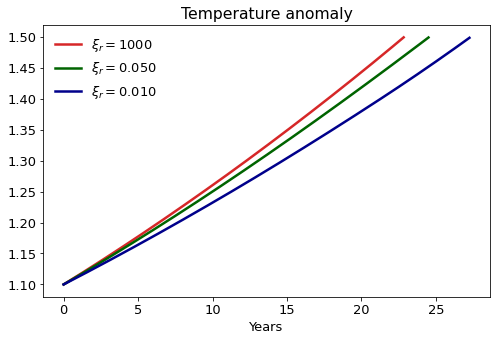

In [26]:
# Intensity tech, I
plt.plot(res_1000_1["years"][:t_15_1000], res_1000_1["states"][:t_15_1000, 1], 
         label="$\\xi_r = 1000$", color="C3")
# plt.plot(res_7p5_1["years"], res_7p5_1["distorted_tech_prob"], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"][:t_15_5], res_5_1["states"][:t_15_5, 1], label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"], res_2p5_1["distorted_tech_prob"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"], res_01_1["distorted_tech_prob"])
plt.plot(res_1_1["years"][:t_15_1], res_1_1["states"][:t_15_1, 1],
        label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_1["years"], res_test_1["distorted_tech_prob"],
#         label="$\\xi_r = 0.01$")


plt.title("Temperature anomaly")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/cut/Yt.pdf")

(-0.001, 0.05)

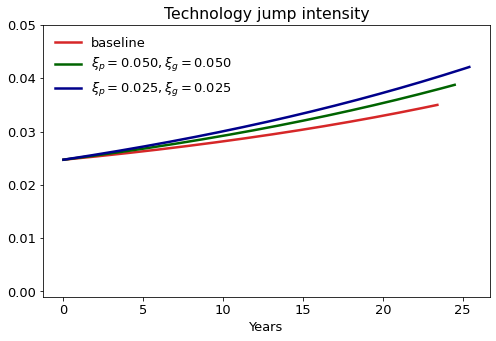

In [29]:
# Intensity tech, I

plt.plot(res_base_1["years"][:t_15_b], np.exp(res_base_1["states"][:, 2][:t_15_b]), 
         label="baseline", color="C3")

plt.plot(res_5_1["years"][:t_15_5], np.exp(res_5_1["states"][:, 2][:t_15_5]), 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")

plt.plot(res_25_1["years"][:t_15_25], np.exp(res_25_1["states"][:,2][:t_15_25]),
        label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")




plt.title("Technology jump intensity")
plt.legend()
plt.xlabel("Years")
plt.ylim(-0.001, 0.05)
# plt.savefig("./figures/xi_comparison/20damage/Lt_1p5.pdf")

Text(0.5, 0, 'Years')

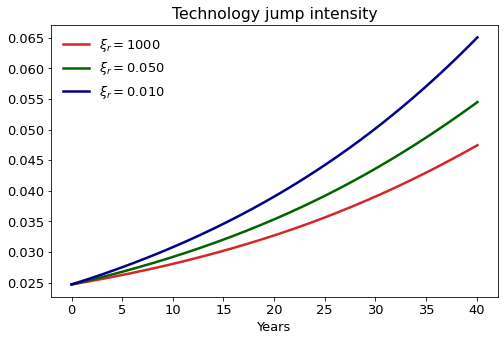

In [30]:
# Intensity tech, I
plt.plot(res_1000_1["years"], np.exp(res_1000_1["states"][:, 2]), 
         label="$\\xi_r = 1000$", color="C3")
# plt.plot(res_7p5_1["years"], res_7p5_1["distorted_tech_prob"], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"], np.exp(res_5_1["states"][:, 2]), label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"], res_2p5_1["distorted_tech_prob"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"], res_01_1["distorted_tech_prob"])
plt.plot(res_1_1["years"], np.exp(res_1_1["states"][:, 2]),
        label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_1["years"], res_test_1["distorted_tech_prob"],
#         label="$\\xi_r = 0.01$")


plt.title("Technology jump intensity")
plt.legend()

plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/Lt.pdf")

Text(0.5, 0, 'Years')

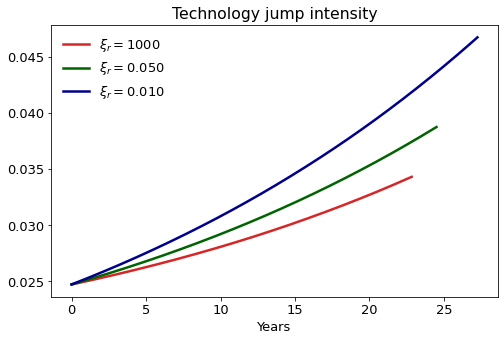

In [31]:
# Intensity tech, I
plt.plot(res_1000_1["years"][:t_15_1000], np.exp(res_1000_1["states"][:t_15_1000, 2]), 
         label="$\\xi_r = 1000$", color="C3")
# plt.plot(res_7p5_1["years"], res_7p5_1["distorted_tech_prob"], label="$\\xi_r = 0.075$")
plt.plot(res_5_1["years"][:t_15_5], np.exp(res_5_1["states"][:t_15_5, 2]), label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_2p5_1["years"], res_2p5_1["distorted_tech_prob"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_1["years"], res_01_1["distorted_tech_prob"])
plt.plot(res_1_1["years"][:t_15_1], np.exp(res_1_1["states"][:t_15_1, 2]),
        label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_1["years"], res_test_1["distorted_tech_prob"],
#         label="$\\xi_r = 0.01$")


plt.title("Technology jump intensity")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/cut/Lt.pdf")

Text(0.5, 0, 'Years')

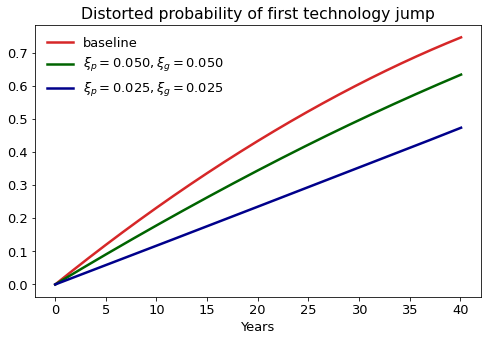

In [34]:
# Intensity tech, I

plt.plot(res_base_1["years"], res_base_1["distorted_tech_prob"], 
         label="baseline", color="C3")


plt.plot(res_5_1["years"], res_5_1["distorted_tech_prob"], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")

plt.plot(res_25_1["years"], res_25_1["distorted_tech_prob"],
        label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")


plt.title("Distorted probability of first technology jump")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/20damage/Tech_jump_first.pdf")

Text(0.5, 0, 'Years')

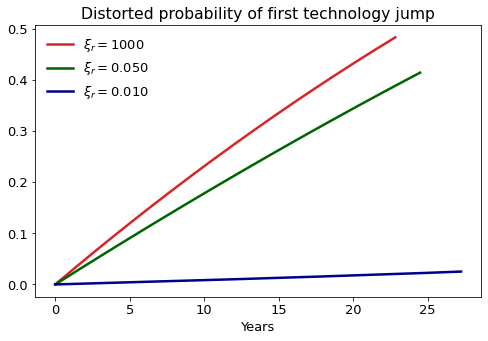

In [35]:
# Intensity tech, I
plt.plot(res_1000_1["years"][:t_15_1000], res_1000_1["distorted_tech_prob"][:t_15_1000], 
         label="$\\xi_r = 1000$", color="C3")
plt.plot(res_5_1["years"][:t_15_5], res_5_1["distorted_tech_prob"][:t_15_5], label="$\\xi_r = 0.050$", color="darkgreen")
plt.plot(res_1_1["years"][:t_15_1], res_1_1["distorted_tech_prob"][:t_15_1],
        label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_1["years"], res_test_1["distorted_tech_prob"],
#         label="$\\xi_r = 0.01$")


plt.title("Distorted probability of first technology jump")
plt.legend()
plt.xlabel("Years")
# plt.savefig("./figures/xi_comparison/cut/Tech_jump_first.pdf")

Text(0.5, 1.0, 'Distorted probability of first technology jump')

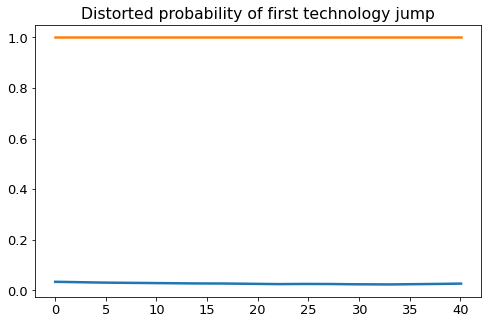

In [36]:
# Intensity tech, I
plt.plot(res_1_1["years"], res_1_1["gt_tech"])
plt.plot(res_1000_1["years"], res_1000_1["gt_tech"])

plt.title("Distorted probability of first technology jump")
# plt.legend()
# plt.savefig("./figures/xi_comparison/Tech_jump_first.pdf")

Text(0.5, 1.0, 'Distorted probability of second technology jump')

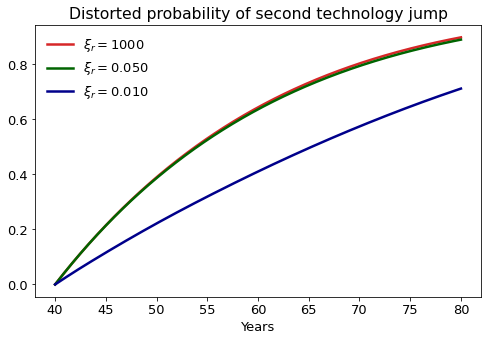

In [37]:
# Intensity tech, II
plt.plot(res_1000_2["years"], res_1000_2["distorted_tech_prob"], 
         label="$\\xi_r = 1000$", color="C3")
# plt.plot(res_7p5_2["years"], res_7p5_2["distorted_tech_prob"], label="$\\xi_r = 0.075$")
plt.plot(res_5_2["years"], res_5_2["distorted_tech_prob"], 
         label="$\\xi_r = 0.050$", color="darkgreen")
# plt.plot(res_2p5_2["years"], res_2p5_2["distorted_tech_prob"], label="$\\xi_r = 0.025$")
# plt.plot(res_01_2["years"], res_01_2["distorted_tech_prob"], label="$\\xi_r = 0.025$")
plt.plot(res_1_2["years"], res_1_2["distorted_tech_prob"], 
         label="$\\xi_r = 0.010$", color="darkblue")

# plt.plot(res_test_2["years"], res_test_2["distorted_tech_prob"], 
#          label="$mix$")


plt.legend()
plt.xlabel("Years")
plt.title("Distorted probability of second technology jump")
# plt.savefig("./figures/xi_comparison/Tech_jump_second.pdf")

Text(0.5, 1.0, 'Distorted probability of second technology jump')

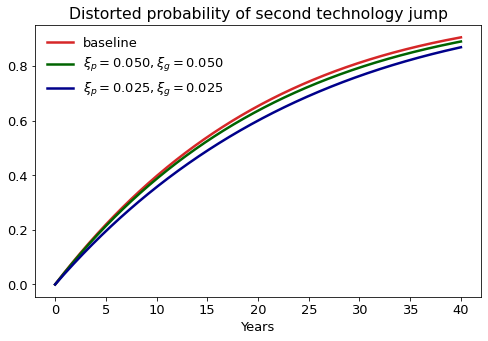

In [40]:
# Intensity tech, II
plt.plot(res_base_2["years"] - 40, res_base_2["distorted_tech_prob"], 
         label="baseline", color="C3")


plt.plot(res_5_2["years"] - 40, res_5_2["distorted_tech_prob"], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")


plt.plot(res_25_2["years"] - 40, res_25_2["distorted_tech_prob"], 
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")

plt.legend()
plt.xlabel("Years")
plt.title("Distorted probability of second technology jump")
# plt.savefig("./figures/xi_comparison/20damage/Tech_jump_second.pdf")

Text(0.5, 1.0, 'Distorted probability of damage changes')

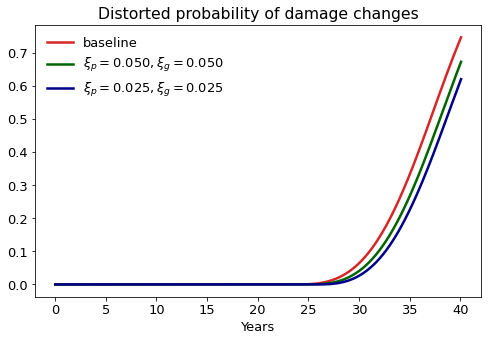

In [44]:
# damage

plt.plot(res_base_1["years"], res_base_1["distorted_damage_prob"], 
         label="baseline", color="C3")

plt.plot(res_5_1["years"], res_5_1["distorted_damage_prob"], 
         label="$\\xi_p = 0.050, \\xi_g = 0.050$", color="darkgreen")

plt.plot(res_25_1["years"], res_25_1["distorted_damage_prob"],
         label="$\\xi_p = 0.025, \\xi_g = 0.025$", color="darkblue")



plt.legend()
plt.xlabel("Years")
plt.title("Distorted probability of damage changes")
# plt.savefig("./figures/xi_comparison/20damage/Damage_prob.pdf")

In [45]:
res_5_1["gt_dmg"].shape

(20, 482)

Text(0.5, 0, '$\\gamma_3$')

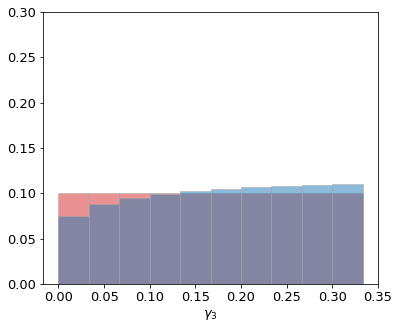

In [48]:
# histogram of gamma_3
NUM_DAMAGE = res_5_1["gt_dmg"].shape[0]
gamma_3_list = np.linspace(0., 1./3., NUM_DAMAGE)

# γ3_distort = np.load("γ3_5.npy")

γ3_distort = res_5_1["gt_dmg"][:, -1] 
plt.figure(figsize=(6,5))
plt.hist(gamma_3_list, weights=np.ones(len(gamma_3_list)) / len(gamma_3_list), 
         alpha=0.5, color="C3", ec="darkgray")
plt.hist(gamma_3_list, weights= γ3_distort / np.sum(γ3_distort), 
         alpha=0.5, color="C0", ec="darkgray")
plt.ylim(0, 0.3)
plt.xlabel("$\\gamma_3$")
# plt.savefig("./figures/xi_comparison/20damage/damage_distort.pdf")

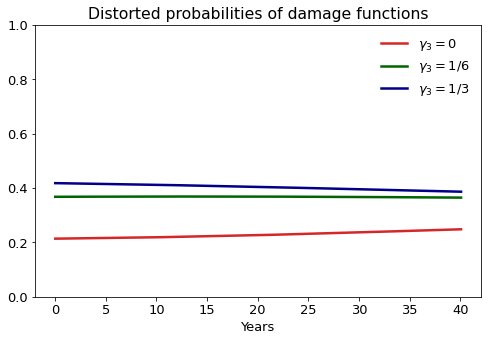

In [666]:
gt = res_5_1["gt_dmg"]/ np.sum(res_5_1["gt_dmg"], axis=0)

g1 = gt[0]
g2 = gt[1]
g3 = gt[2]
plt.plot(res_5_1["years"], g1, color="C3")
plt.plot(res_5_1["years"], g2, color="darkgreen")
plt.plot(res_5_1["years"], g3, color="darkblue")
plt.ylim(0, 1)
plt.legend(["$\\gamma_3 = 0$", "$\\gamma_3 = 1/6$", "$\\gamma_3 = 1/3$"])
plt.xlabel("Years")
plt.title("Distorted probabilities of damage functions")
# plt.savefig("./figures/xi_comparison/simple/gt_damage.pdf")

Text(0.5, 0, '$\\gamma_3$')

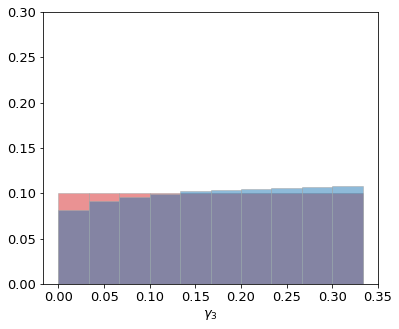

In [49]:
# histogram of gamma_3
gamma_3_list = np.linspace(0., 1./3., 20)

γ3_distort = np.load("γ3_5.npy")

plt.figure(figsize=(6,5))
plt.hist(gamma_3_list, weights=np.ones(len(gamma_3_list)) / len(gamma_3_list), 
         alpha=0.5, color="C3", ec="darkgray")
plt.hist(gamma_3_list, weights= γ3_distort / np.sum(γ3_distort), 
         alpha=0.5, color="C0", ec="darkgray")
plt.ylim(0, 0.3)
plt.xlabel("$\\gamma_3$")
# plt.savefig("./figures/5/damage_distort.pdf")

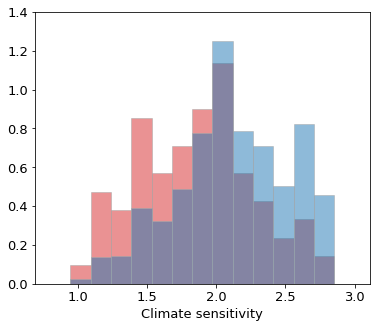

In [52]:
# histogram of beta_f
theta_ell = pd.read_csv("../data/model144.csv", header=None).to_numpy()[:, 0]
pi_c_o = np.ones(len(theta_ell)) / len(theta_ell)
# pi_c = np.load("πc_5.npy")
pi_c = res_5_1["pic_t"][:, -1]
plt.figure(figsize=(6,5))

plt.hist(theta_ell, weights=pi_c_o, bins=np.linspace(0.8, 3., 16), density=True, 
         alpha=0.5, ec="darkgrey", color="C3")
plt.hist(theta_ell, weights=pi_c, bins=np.linspace(0.8, 3., 16), density=True, 
         alpha=0.5, ec="darkgrey", color="C0")

plt.ylim(0, 1.4)
plt.xlabel("Climate sensitivity")
# plt.savefig("./figures/xi_comparison/20damage/worstcase.pdf")
plt.show()
